<a href="https://colab.research.google.com/github/KashyapCKotak/AI-ML-experiments/blob/master/StockTF1_4Sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Data/2015-02-02-To-2019-5-19-5-Min.csv', index_col = 0)
df_stock = dataset.copy()
df_stock = df_stock.dropna()
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]

In [21]:
df_stock.shape

(79005, 4)

In [0]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

                              Open      High       Low     Close
Time                                                            
2015-02-04T13:20:00+0530  0.180503  0.178966  0.181630  0.180622
2015-02-04T13:25:00+0530  0.180693  0.178966  0.182492  0.179551
2015-02-04T13:30:00+0530  0.179621  0.178517  0.182147  0.179239


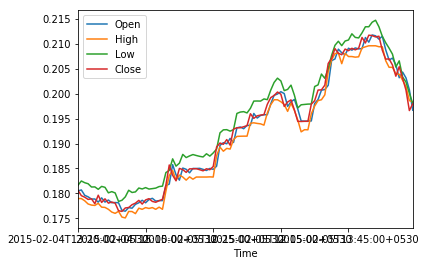

In [6]:
print(df_stock_norm[0:3])
df_stock_norm[:100].plot()
#plt.plot(df_stock_norm[:1000])
#plt.show()

In [0]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20: 19 for training and 1 for target

In [0]:
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() 
    print(data_raw)
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    print("data shape:",data.shape)
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    print("valid_set_size shape:",valid_set_size)
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    print("test_set_size shape:",test_set_size)
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    print("train_set_size shape:",train_set_size)
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [9]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

[[0.18050298 0.17896628 0.18163026 0.1806223 ]
 [0.18069311 0.17896628 0.18249156 0.17955056]
 [0.17962147 0.17851714 0.18214704 0.17923941]
 ...
 [0.50116671 0.4999309  0.50113691 0.50008643]
 [0.50021606 0.50407684 0.50251499 0.50630942]
 [0.50643851 0.50502695 0.50647695 0.50475367]]
data shape: (78985, 20, 4)
valid_set_size shape: 7898
test_set_size shape: 7898
train_set_size shape: 63189
x_train.shape =  (63189, 19, 4)
y_train.shape =  (63189, 4)
x_valid.shape =  (7898, 19, 4)
y_valid.shape =  (7898, 4)
x_test.shape =  (7898, 19, 4)
y_test.shape =  (7898, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
#print(x_train[0:4])
#print(y_train[0:4])

In [0]:
# parameters & Placeholders 
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 30 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [12]:
perm=[0,1]
x_train[perm]

array([[[0.18050298, 0.17896628, 0.18163026, 0.1806223 ],
        [0.18069311, 0.17896628, 0.18249156, 0.17955056],
        [0.17962147, 0.17851714, 0.18214704, 0.17923941],
        [0.17931034, 0.17787797, 0.18194033, 0.17878997],
        [0.17886095, 0.1776534 , 0.18128574, 0.17891098],
        [0.17887823, 0.1775843 , 0.18130297, 0.17792567],
        [0.1782387 , 0.17801617, 0.18082064, 0.17963699],
        [0.17910293, 0.17723881, 0.18140633, 0.17818496],
        [0.17825598, 0.17718698, 0.18121684, 0.17891098],
        [0.17867081, 0.17680694, 0.18011438, 0.17804667],
        [0.17811771, 0.17625415, 0.18035554, 0.17827139],
        [0.17816956, 0.17599502, 0.18009715, 0.17804667],
        [0.17811771, 0.17640962, 0.17839179, 0.1765255 ],
        [0.17659666, 0.17525221, 0.17861572, 0.17638721],
        [0.17642382, 0.17507946, 0.17930476, 0.17707865],
        [0.17714977, 0.17637507, 0.18063116, 0.17716508],
        [0.17702878, 0.17635779, 0.18018328, 0.17773552],
        [0.177

In [0]:
# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        index_in_epoch = 0; #repeat the above steps
        start = index_in_epoch
        index_in_epoch += batch_size    
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [14]:
print(tf.__version__)

1.14.0


In [15]:
#RNN 
#layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#         for layer in range(n_layers)]
# LSTM  
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#        for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

#GRU 
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
          for layer in range(n_layers)] 
                                                                  
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
print(type(rnn_outputs))
print(rnn_outputs.shape)
print(type(states))
print(states)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
print(type(stacked_rnn_outputs))
print(stacked_rnn_outputs.shape)
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
print(type(stacked_outputs))
print(stacked_outputs.shape)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
print(type(outputs))
print(outputs.shape)
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
print(type(outputs))
print(outputs.shape)


W0706 07:42:05.457600 139968947033984 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0706 07:42:05.459212 139968947033984 deprecation.py:323] From <ipython-input-15-95594ff860b7>:2: GRUCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
W0706 07:42:05.461248 139968947033984 deprecation.py:323] From <ipython-input-15-95594ff860b7>:4: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for up

<class 'tensorflow.python.framework.ops.Tensor'>
(?, 19, 200)
<class 'tuple'>
(<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 200) dtype=float32>, <tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 200) dtype=float32>)
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 200)
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 4)
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 19, 4)
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 4)


In [0]:
# #RNN 
# layers2 = [tf.keras.layers.SimpleRNNCell(units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]
# # LSTM  
# #layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
# #        for layer in range(n_layers)]

# #LSTM with peephole connections
# #layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
# #                                  activation=tf.nn.leaky_relu, use_peepholes = True)
# #          for layer in range(n_layers)]

# #GRU 
# #layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
# #          for layer in range(n_layers)] 
                                                                  
# multi_layer_cell2 = tf.keras.layers.StackedRNNCells(layers)
# final_rnn = tf.keras.layers.RNN(cell=multi_layer_cell,return_state=True,return_sequences=True)
# rnn_outputs2=final_rnn(X)
# rnn_states2=rnn_outputs2[1:]
# rnn_outputs2=rnn_outputs2[0]
# print(type(rnn_outputs2))
# print(rnn_outputs2.shape)
# print(rnn_states2)
# stacked_rnn_outputs2 = tf.reshape(rnn_outputs2, [-1, n_neurons])
# print(type(stacked_rnn_outputs2))
# print(stacked_rnn_outputs2.shape)
# stacked_outputs2 = tf.keras.layers.Dense(stacked_rnn_outputs2, n_outputs)
# print(type(stacked_outputs2))
# print(stacked_outputs2.shape)
# outputs2 = tf.reshape(stacked_outputs2, [-1, n_steps, n_outputs])
# print(type(outputs2))
# print(outputs2.shape)
# outputs2 = outputs2[:,n_steps-1,:] # keep only last output of sequence
# print(type(outputs2))
# print(outputs2.shape)


In [0]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [18]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.031322/0.165972
5.00 epochs: MSE train/valid = 0.000029/0.000011
10.00 epochs: MSE train/valid = 0.000029/0.000008
15.00 epochs: MSE train/valid = 0.000028/0.000006
20.00 epochs: MSE train/valid = 0.000032/0.000007
25.00 epochs: MSE train/valid = 0.000028/0.000025
30.00 epochs: MSE train/valid = 0.000027/0.000006


In [19]:
#checking prediction output nos 
y_test_pred.shape

(7898, 4)

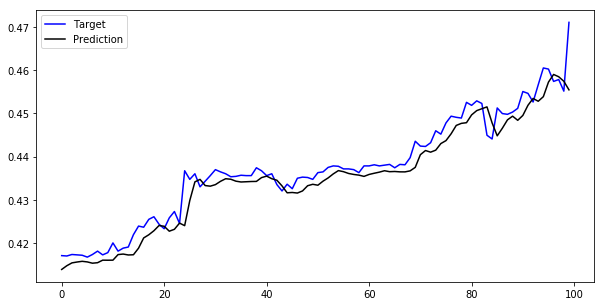

In [23]:
# ploting the graph
comp = pd.DataFrame({'Column1':y_test[:100,3],'Column2':y_test_pred[:100,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

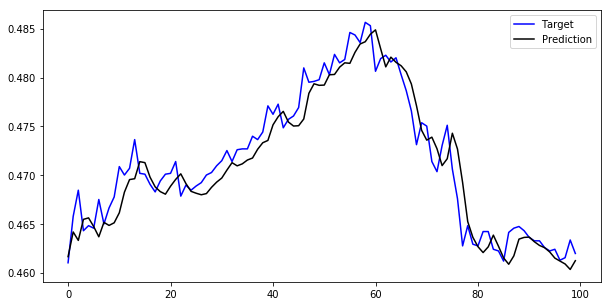

In [22]:
# ploting the graph
comp = pd.DataFrame({'Column1':y_test[100:200,3],'Column2':y_test_pred[100:200,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

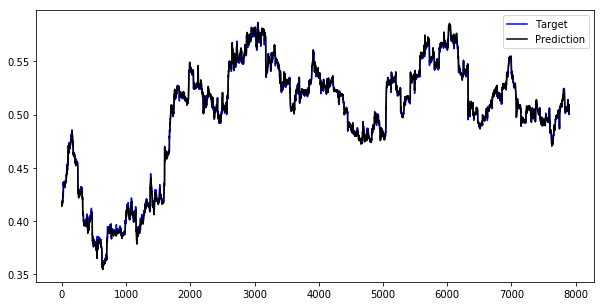

In [33]:
# ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,3],'Column2':y_test_pred[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

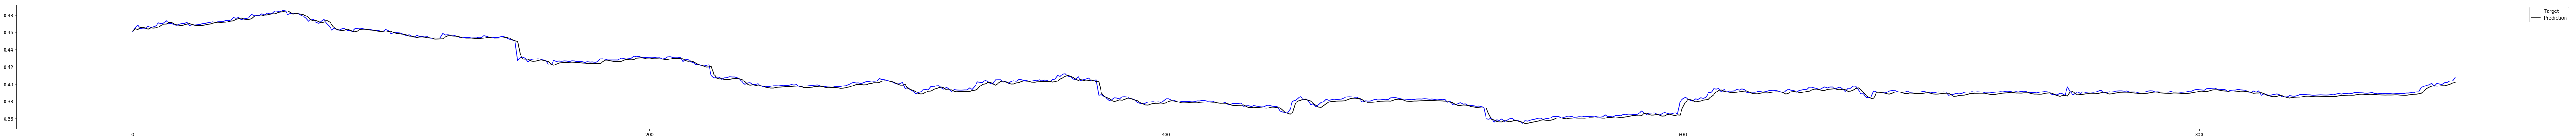

In [39]:
# ploting the graph
comp = pd.DataFrame({'Column1':y_test[100:1000,3],'Column2':y_test_pred[100:1000,3]})
plt.figure(figsize=(100,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()